In [6]:
import pandas as pd
import numpy as np
import os
import time
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

def load_data(data_path, data_path_time):
    
    #Timer start
    time_start=time.time()
    
    #Load data
    data_list = []
    for fname in sorted(os.listdir(data_path)):
        subject_data_path = os.path.join(data_path, fname)
        print(subject_data_path)
        if not os.path.isfile(subject_data_path): continue
        data_list.append(
            pd.read_csv(subject_data_path,
                        sep='|', 
                        header=None,
                        names = [
                                'CREDIT_SCORE',
                                'FIRST_PAYMENT_DATE',
                                'FIRST_TIME_HOMEBUYER_FLAG',
                                '4','5','6',
                                'NUMBER_OF_UNITS',
                                'OCCUPANCY_STATUS',
                                '9',
                                'ORIGINAL_DTI_RATIO',
                                'ORIGINAL_UPB',
                                'ORIGINAL_LTV',
                                'ORIGINAL_INTEREST_RATE',
                                'CHANNEL',
                                '15',
                                'PRODUCT_TYPE',
                                'PROPERTY_STATE',
                                'PROPERTY_TYPE',
                                '19',
                                'LOAN_SQ_NUMBER',
                                'LOAN_PURPOSE',
                                'ORIGINAL_LOAN_TERM',
                                'NUMBER_OF_BORROWERS',
                                '24','25','26'
                        ],
                        usecols=[
                            'CREDIT_SCORE',
                            'FIRST_TIME_HOMEBUYER_FLAG',
                            'NUMBER_OF_UNITS',
                            'OCCUPANCY_STATUS',
                            'ORIGINAL_DTI_RATIO',
                            'ORIGINAL_UPB',
                            'ORIGINAL_LTV',
                            'ORIGINAL_INTEREST_RATE',
                            'CHANNEL',
                            'PROPERTY_TYPE',
                            'LOAN_SQ_NUMBER',
                            'LOAN_PURPOSE',
                            'ORIGINAL_LOAN_TERM',
                            'NUMBER_OF_BORROWERS'
                        ],
                        dtype={'CREDIT_SCORE':np.float_, 
                               'FIRST_TIME_HOMEBUYER_FLAG':np.str, 
                               'NUMBER_OF_UNITS':np.int_, 
                               'OCCUPANCY_STATUS':np.str,
                               'ORIGINAL_DTI_RATIO':np.float_,
                               'ORIGINAL_UPB':np.float_,
                               'ORIGINAL_LTV':np.float_,
                               'ORIGINAL_INTEREST_RATE':np.float_,
                               'CHANNEL':np.str,
                               'PROPERTY_TYPE':np.str,
                               'LOAN_SQ_NUMBER':np.str,
                               'LOAN_PURPOSE':np.str,
                               'ORIGINAL_LOAN_TERM':np.int_,
                               'NUMBER_OF_BORROWERS':np.int_},
                        low_memory=False
                        )
        )
    data = pd.concat(data_list)
    
    #Load data with time
    data_p_list=[]
    for fname in sorted(os.listdir(data_path_time)):
        subject_data_path = os.path.join(data_path_time, fname)
        print(subject_data_path)
        if not os.path.isfile(subject_data_path): continue
        data_p_list.append(
            pd.read_csv(subject_data_path,
                             sep='|',
                             header=None,
                             usecols=[0,3,4],
                             dtype={'0':np.str, '3':np.str, '4':np.int_}
                            )
        )
    data_p = pd.concat(data_p_list)
    
    #Calculate default
    data_p[3] = data_p[3].astype(str)
    clean_index = data_p.iloc[:,1].str.isdigit()
    data_p_cleaned = data_p[clean_index].copy()
    data_p_cleaned[3] = data_p_cleaned[3].astype(int)
    data_less_than_48 = data_p_cleaned[data_p_cleaned[4] < 48]
    data_default = data_less_than_48[data_less_than_48[3] > 2]
    default_index = data['LOAN_SQ_NUMBER'].isin(data_default[0].tolist())
    data['default_flag']=default_index
    data.drop(columns=['LOAN_SQ_NUMBER'], inplace=True)
    data.to_csv('data/historical_data_withflag.csv',index=False)
    
    #Imputation
    CREDIT_SCORE = data['CREDIT_SCORE']
    OIR = data['ORIGINAL_DTI_RATIO']
    LTV = data['ORIGINAL_LTV']
    CREDIT_clean = CREDIT_SCORE[CREDIT_SCORE != 9999]
    OIR_clean = OIR[OIR != 999]
    LTV_clean = LTV[LTV != 999]
    data['CREDIT_SCORE'] = data['CREDIT_SCORE'].apply(lambda x : CREDIT_clean.mean() if x == 9999 else x)
    data['ORIGINAL_DTI_RATIO'] = data['ORIGINAL_DTI_RATIO'].apply(lambda x : OIR_clean.mean() if x == 999 else x)
    data['ORIGINAL_LTV'] = data['ORIGINAL_LTV'].apply(lambda x : LTV_clean.mean() if x == 999 else x)
    
    
    
    #Timer stop
    time_end=time.time()
    print('Finished loading, time cost:',time_end-time_start,'s')
    return data

def train(data):
    #Get dummy value
    output_array = np.asarray(data['default_flag'].astype(int))
    input_array = np.c_[
        data[['CREDIT_SCORE',#0
              'ORIGINAL_DTI_RATIO',#1
              'ORIGINAL_UPB',#2
              'ORIGINAL_LTV',#3
              'ORIGINAL_LOAN_TERM',#4
              'ORIGINAL_INTEREST_RATE'#5
             ]],
        np.asarray(pd.get_dummies(data['FIRST_TIME_HOMEBUYER_FLAG'])),
        np.asarray(pd.get_dummies(data['NUMBER_OF_UNITS'])),
        np.asarray(pd.get_dummies(data['OCCUPANCY_STATUS'])),
        np.asarray(pd.get_dummies(data['CHANNEL'])),
        np.asarray(pd.get_dummies(data['PROPERTY_TYPE'])),
        np.asarray(pd.get_dummies(data['LOAN_PURPOSE'])),
        np.asarray(pd.get_dummies(data['NUMBER_OF_BORROWERS']))
    ]
    
    #Normalise
    min_max_scaler = preprocessing.MinMaxScaler()
    input_array_N = min_max_scaler.fit_transform(input_array)
    
    X = input_array_N
    y = output_array
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.3, 
        random_state=13
    )
    
    classifier = LogisticRegression(
        solver='saga',
        max_iter=1500
    )
    
    classifier.fit(X_train,y_train)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    viz = plot_roc_curve(
        classifier, 
        X_test, 
        y_test,
        name='ROC'.format(0),
        alpha=0.3, lw=1, ax=ax
    )
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 500)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    return classifier


    
    
    

In [2]:
if __name__ == '__main__':
    data_path = 'data/2008/data'
    data_path_time = 'data/2008/data_time'
    data = load_data(data_path, data_path_time)

data/2008/data\historical_data1_Q12008.txt
data/2008/data\historical_data1_Q22008.txt
data/2008/data\historical_data1_Q32008.txt
data/2008/data\historical_data1_Q42008.txt
data/2008/data_time\historical_data1_time_Q12008.txt


G:\Anaconda\envs\FYP\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data/2008/data_time\historical_data1_time_Q22008.txt
data/2008/data_time\historical_data1_time_Q32008.txt
data/2008/data_time\historical_data1_time_Q42008.txt
Finished loading, time cost: 397.4113154411316 s


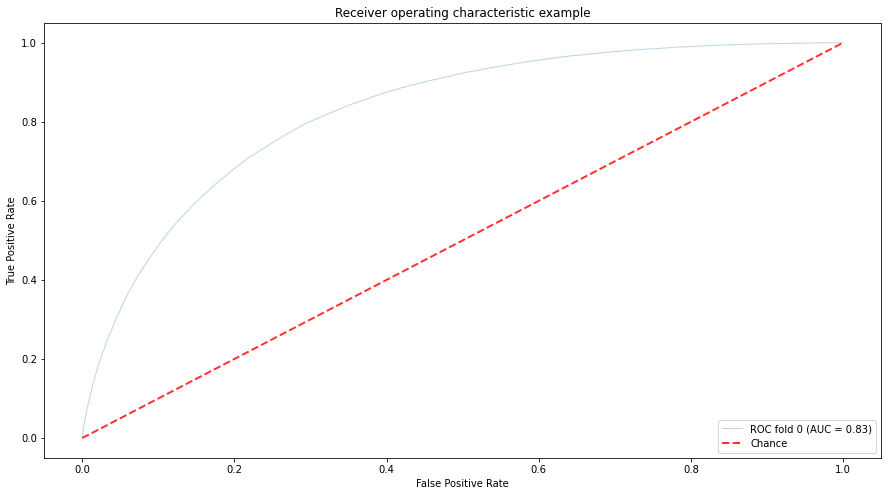

In [7]:
    model= train(data)
   